In [100]:
import numpy as np, numba, matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

plt.style.use(['science','notebook','grid', 'dark_background'])

The Laplace Equation is $$\nabla^2 V=0$$ The Dirichlet Boundary Condutions for Conductors and Insulators over the Domains $\Omega_1$ and $\Omega_2$ respectively say that $$V_{\Omega_1}(\vec r)=V(x,y,z)$$ $$\frac{\partial V_{\Omega_2}}{\partial n}=0$$ There's no normal component of the Electric Field at the Insulator surfaces.

In $\mathbb R^3$, the Laplace Equation $\displaystyle\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}+\frac{\partial^2 V}{\partial z^2}$ can be discretely approximated as $$\frac{V_{i+1,j,k}+V_{i-1,j,k}-2V_{i,j,k}}{\delta x^2}+\frac{V_{i,j+1,k}+V_{i,j-1,k}-2V_{i,j,k}}{\delta y^2}+\frac{V_{i,j,k+1}+V_{i,j,k-1}-2V_{i,j,k}}{\delta z^2}=0$$ Notice that $\delta x=\delta y$ in the grid and hence $V(x_i,y_j)$ is $$V_{i,j,k}=\frac 16(V_{i+1,j,k}+V_{i-1,j,k}+V_{i,j+1,k}+V_{i,j-1,k}+V_{i,j,k+1}+V_{i,j,k-1})$$ Since this is only a **property** of the true solution, let's set $V_{i,j,k}$ to this expression and it will eventually converge to the true solution.

Consider two parallel plates held at constant potentials ($V_0$ and 0) surrounded by an Insulating boundary with a constant charge of 0. The Conducting box provides a good approximation of the Infinite Boundary Condiction $V\to 0$ as $\vec r\to \infty$. Let's
- Solve $\displaystyle \nabla^2(V/V_0)$ to keep the problem dimensionless for Python,
- Set $V/V_0=0.5$ everywhere, and
- Use a 100 x 100 x 100 grid. 

Only if $V$ satisfies this condition, then it also satisfies $\nabla^2 V=0$.

In [72]:
N = 100
grid = np.zeros((N, N, N)) + 0.5

Location of plates, Positive and Negative Mask:

In [73]:
grid[30:70, 30:70, 20] = 1
grid[30:70, 30:70, 80] = 0

mask_pos = grid == 1
mask_neg = grid == 0

Text(0, 0.5, '$y$')

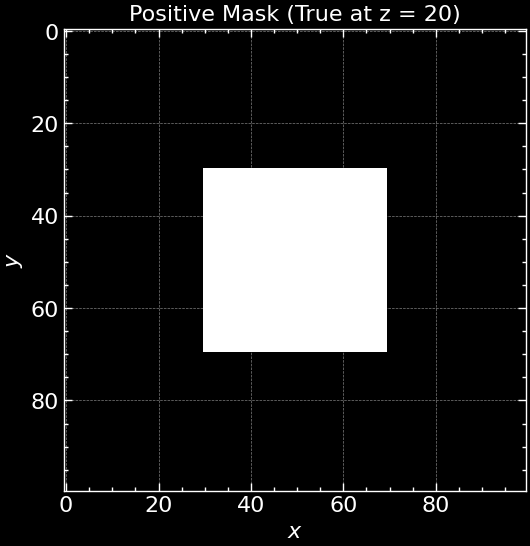

In [74]:
plt.imshow(mask_pos[:,:,20], cmap = 'gist_heat')

plt.title('Positive Mask (True at z = 20)')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Text(0, 0.5, '$y$')

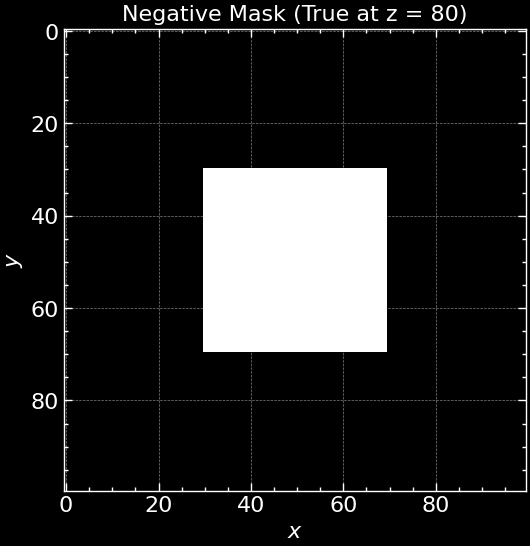

In [75]:
plt.imshow(mask_neg[:,:,80], cmap = 'gist_heat')

plt.title('Negative Mask (True at z = 80)')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Initial Guess: Potential goes from $V/V_0=1$ at the left to 0 at the right.

In [76]:
yv, xv, zv = np.meshgrid(np.arange(N), np.arange(N), np.arange(N))
grid = 1 - 0.01 * zv

xv[:,0,:]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ...,
       [97, 97, 97, ..., 97, 97, 97],
       [98, 98, 98, ..., 98, 98, 98],
       [99, 99, 99, ..., 99, 99, 99]])

Text(0, 0.5, '$y$')

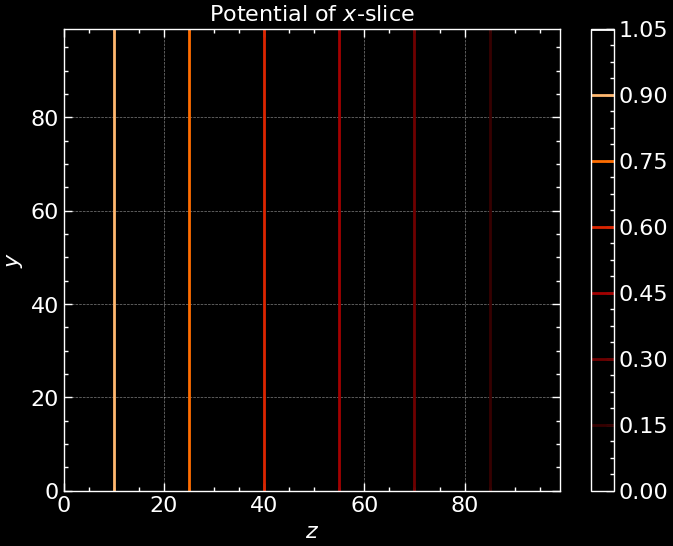

In [77]:
plt.contour(grid[0], cmap = 'gist_heat')
plt.colorbar()

plt.title(r'Potential of $x$-slice')
plt.xlabel(r'$z$')
plt.ylabel(r'$y$')

The $y$-slice would be equivalent to this, just with 'our' $x$ going along the $y$-axis.

The Potential $$V_{i,j,k}=\frac 16(V_{i+1,j,k}+V_{i-1,j,k}+V_{i,j+1,k}+V_{i,j-1,k}+V_{i,j,k+1}+V_{i,j,k-1})$$ can be represented by a Convolution whose analog in $\mathbb R^3$ is 

In [78]:
kern = generate_binary_structure(3, 1).astype(float) / 6
kern[1,1,1] = 0

kern

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.16666667, 0.        ],
        [0.16666667, 0.        , 0.16666667],
        [0.        , 0.16666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]]])

We need to Convolve this with our grid. What follows is a function used to set $\displaystyle\frac{\partial V}{\partial n}$ at all the Boundaries:

In [79]:
def neumann(a):
    a[0,:,:] = a[1,:,:]; a[-1,:,:] = a[-2,:,:]
    a[:,0,:] = a[:,1,:]; a[:,-1,:] = a[:,-2,:]
    a[:,:,0] = a[:,:,1]; a[:,:,-1] = a[:,:,-2]

    return a

In [80]:
err_th = 1e-17
err = [1e-09]

while err[-1] > err_th:
    grid_updated = convolve(grid, kern, mode = 'constant')
    grid_updated = neumann(grid_updated)
    
    grid_updated[mask_pos] = 1
    grid_updated[mask_neg] = 0

    err.append(np.mean((grid - grid_updated) ** 2))
    grid = grid_updated

Potential Plot at a given slice:

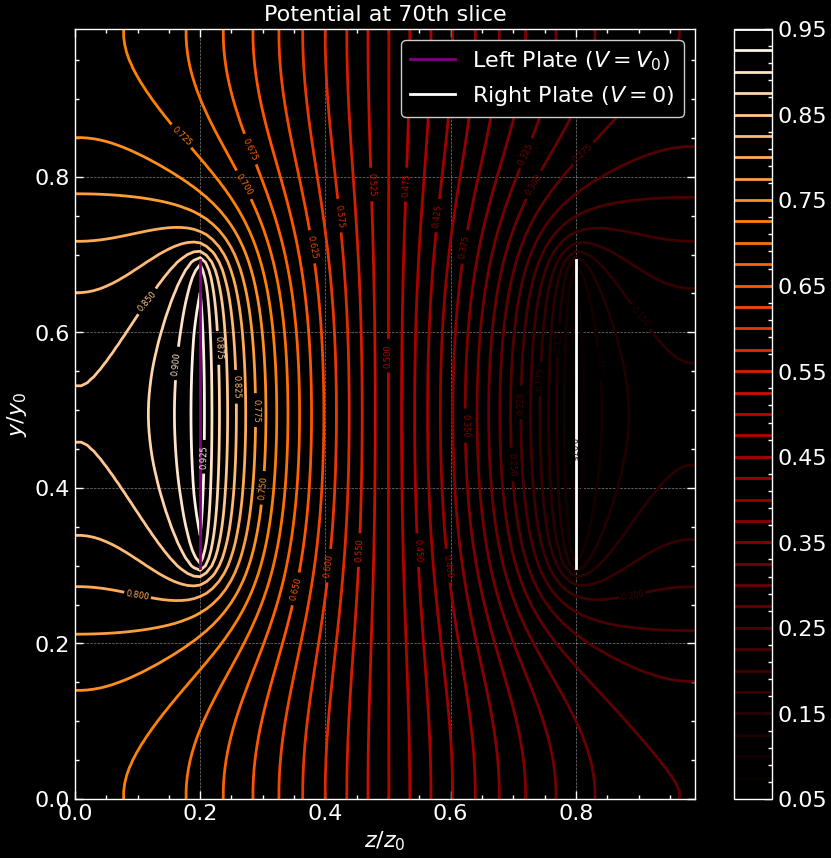

In [88]:
slc = 70 # CHANGE THIS AS YOU PLEASE

plt.figure(figsize = (10, 10))
CS = plt.contour(np.arange(N) / N, np.arange(N) / N, grid[slc], levels = 40, cmap = 'gist_heat')

plt.clabel(CS, CS.levels, inline = True, fontsize = 6)
plt.title(r'Potential at {}th slice'.format(slc))
plt.xlabel(r'$z/z_0$')
plt.ylabel(r'$y/y_0$')

plt.axvline(0.2, ymin = 0.3, ymax = 0.7, color = 'purple', label = r'Left Plate $(V=V_0)$')
plt.axvline(0.8, ymin = 0.3, ymax = 0.7, color = 'white', label = r'Right Plate $(V=0)$')
plt.colorbar()
plt.legend()

As before, the $y$-slice would be equivalent to this.

# Plotting the Error:

The RMSE is $\sqrt{\langle(V_{new}-V_{old})^2\rangle}$ where 'new' is the updated array for the given iteration and 'old' is the original one.

Text(0, 0.5, 'RMSE')

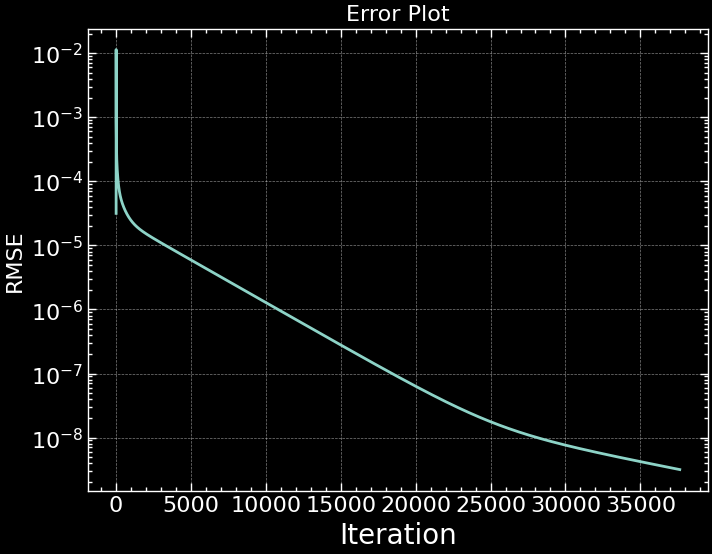

In [89]:
plt.semilogy(np.sqrt(np.array(err)))

plt.title('Error Plot')
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('RMSE')

# Arbitrary Boundary Conditions:

Let's define some boundary conditions: 

In [90]:
edge = np.linspace(-1, 1, 300)

upper_y = np.cos(np.pi * edge / 2)
lower_y = edge ** 4
upper_x = 1 / (np.e ** (-1) - np.e) * (np.exp(edge) - np.e)
lower_x = 0.5 * (edge ** 2 - edge)

In [91]:
xv, yv = np.meshgrid(edge, edge)

The analog of the Potential in $\mathbb R^2$ is $$V(x_i,y_j)=\frac 14\bigg(V(x_{i+1},y_j)+V(x_{i-1},y_j)+V(x_i,y_{j+1})+V(x_i,y_{j-1})\bigg)$$

In [92]:
@numba.jit('f8[:,:](f8[:,:], i8)', nopython = True, nogil = True)
def compute_V(V, n_iter):
    length = len(V[0])
    for n in range(n_iter):
        for i in range(1, length - 1):
            for j in range(1, length - 1):
                V[j][i] = 0.25 * (V[j + 1][i] + V[j - 1][i] + V[j][i + 1] + V[j][i - 1])
    return V

V = np.zeros((300, 300))

V[-1,:] = upper_y
V[0,:] = lower_y
V[:,-1] = upper_x
V[:,0] = lower_x

V = compute_V(V, n_iter = 10000)

Text(0, 0.5, '$y$')

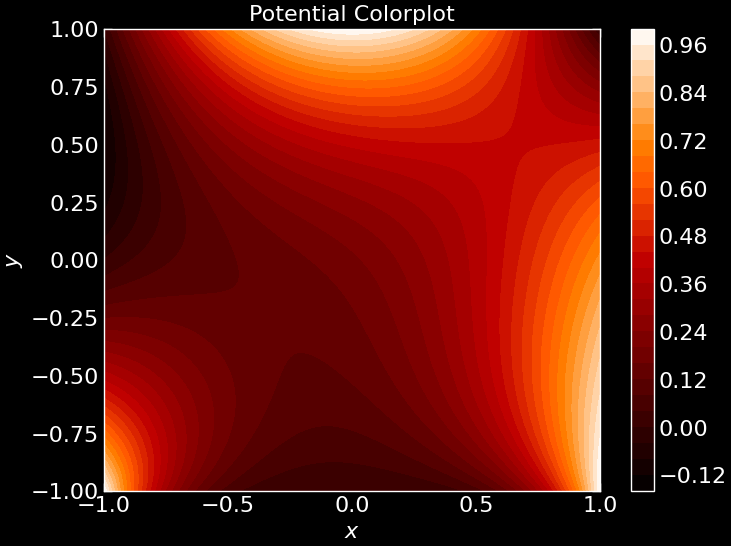

In [93]:
plt.contourf(xv, yv, V, 30, cmap = 'gist_heat')
plt.colorbar()

plt.title('Potential Colorplot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Let's define a constant Potential Block of $V=1$ within the boundary:

Text(0, 0.5, '$y$')

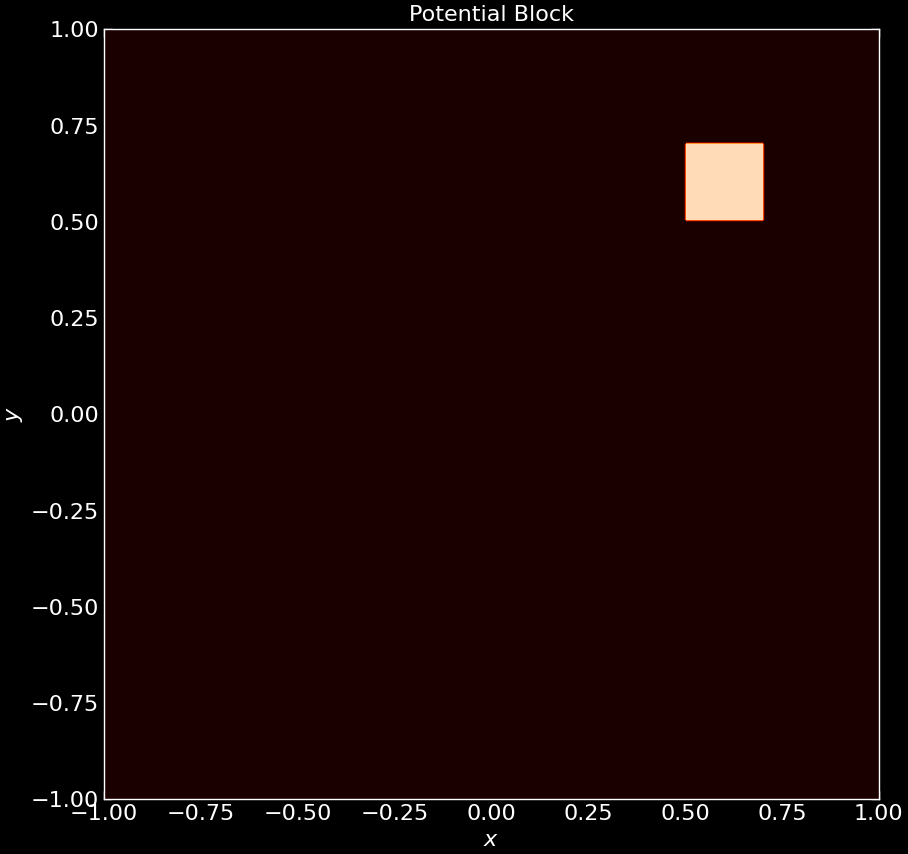

In [94]:
def V_block(x, y):
    return np.select([(x > 0.5) * (x < 0.7) * (y > 0.5) * (y < 0.7),
                      (x <= 0.5) + (x >= 0.7) + (y <= 0.5) + (y >= 0.7)],
                        [1, 0])

plt.figure(figsize = (10, 10))
plt.contourf(xv, yv, V_block(xv, yv), cmap = 'gist_heat')

plt.title('Potential Block')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Let's get the Fixed Potential and the places where it is so.

In [95]:
fixed = V_block(xv, yv)
fixed_bool = fixed != 0

fixed_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Let's redefine the potential function so that it doesn't modify these fixed points: 

In [96]:
@numba.jit('f8[:,:](f8[:,:], b1[:,:], i8)', nopython = True, nogil = True)
def compute_V(V, fixed_bool, n_iter):
    length = len(V[0])
    for n in range(n_iter):
        for i in range(1, length - 1):
            for j in range(1, length - 1):
                if not(fixed_bool[j][i]):
                    V[j][i] = 0.25 * (V[j + 1][i] + V[j - 1][i] + V[j][i + 1] + V[j][i - 1])
    return V

V = np.zeros((300, 300))

V[-1, :] = upper_y
V[0, :] = lower_y
V[:, -1] = upper_x
V[:, 0] = lower_x

V[fixed_bool] = fixed[fixed_bool]
V = compute_V(V, fixed_bool, n_iter = 10000)

Text(0, 0.5, '$y$')

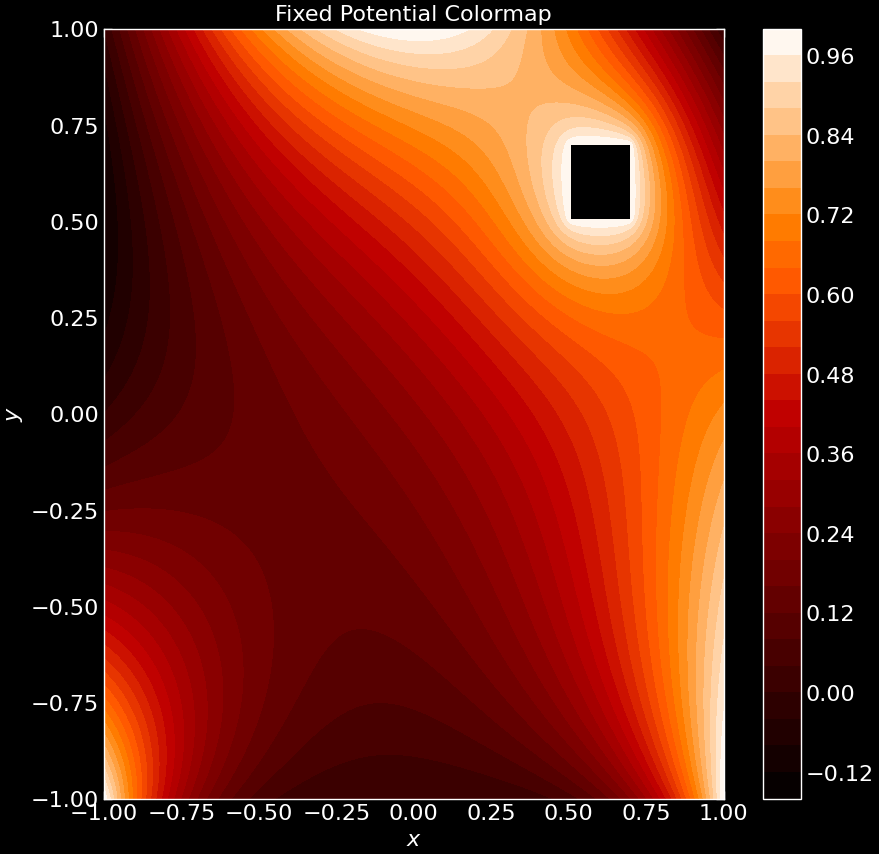

In [97]:
plt.figure(figsize = (10, 10))
plt.contourf(xv, yv, V, 30, cmap = 'gist_heat')
plt.colorbar()

plt.title('Fixed Potential Colormap')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

We can also take a look at the Electric Field magnitudes. Let's use $$\vec E=-\mathrm{grad}\,V$$

Text(0, 0.5, '$y$')

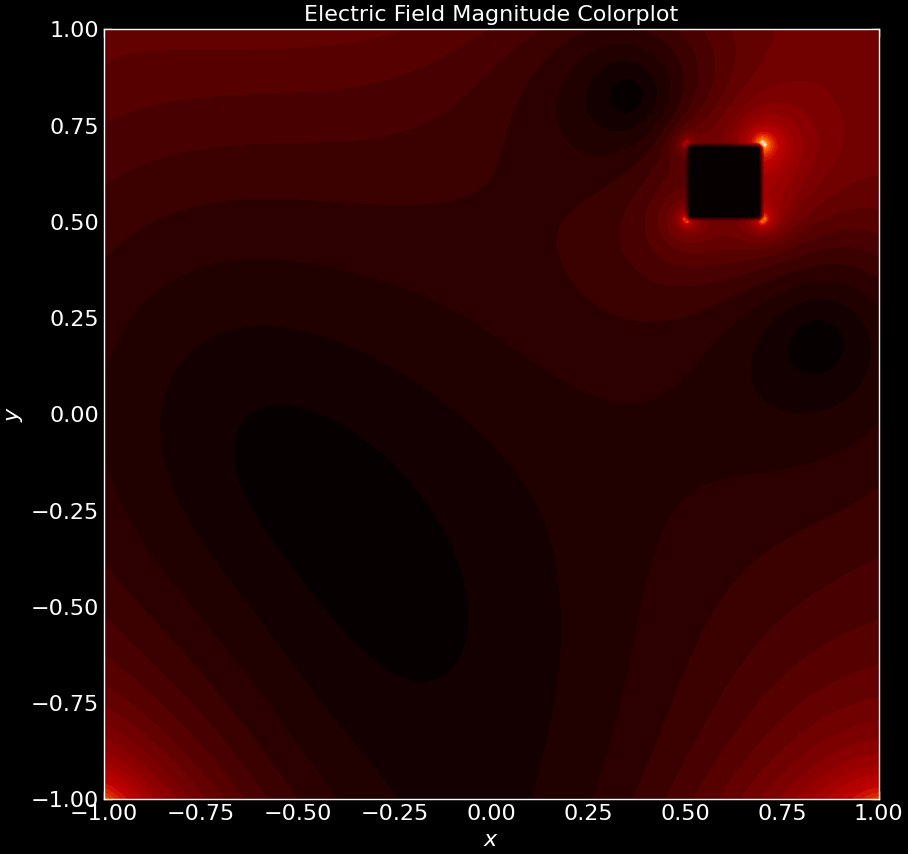

In [104]:
Ex, Ey = np.gradient(-V)
E_mag = np.sqrt(Ex ** 2 + Ey ** 2)

plt.figure(figsize = (10, 10))
plt.contourf(xv, yv, E_mag, 30, cmap = 'gist_heat')

plt.title('Electric Field Magnitude Colorplot')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Let's make an animation:

C:\Users\DELL\AppData\Local\Temp\ipykernel_18384\168109973.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


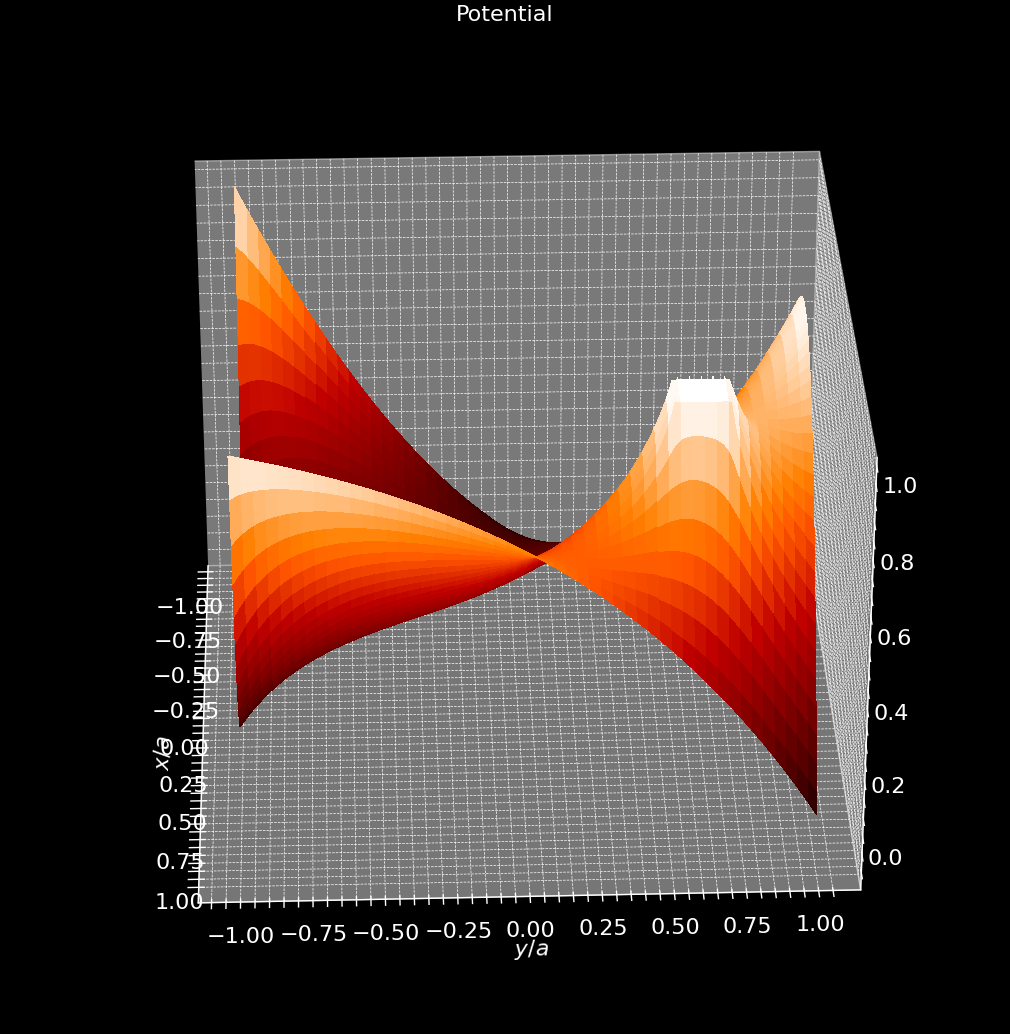

In [103]:
fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig)

def init():
    ax.plot_surface(xv, yv, V, cmap = 'gist_heat', linewidth = 0, antialiased = False)
    
    ax.set_title('Potential')
    ax.set_xlabel(r'$x/a$')
    ax.set_ylabel(r'$y/a$')

    return fig,

def animate(i):
    ax.view_init(elev = 30, azim = 2 * i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func = init, frames = 180, interval = 50)
ani.save('..\Outputs\surf_potential.gif', writer = 'pillow', fps = 20)